In [1]:
import qrcode

from docxtpl import DocxTemplate
import docxtpl
from docx.shared import Mm
import matplotlib.patches as mpatches
import requests

In [2]:
import math
import contextily as ctx

import rasterio
from rasterio.plot import show

import collections

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

from descartes import PolygonPatch

In [4]:
# ruta de carpera donde estan las llaves
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]
ruta

'C:\\Documents\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

In [5]:
path_shp = r'C:\Documents\OneDrive - Ingenio Azucarero Guabira S.A\UTEA_2023\PROYECTO AREA LIBERACION\SEGUIMIENTO2\SHP_SEGUIMIENTO\SHP_SEGUIMIENTO.shp'
path_shp_cat = r'C:\Documents\OneDrive - Ingenio Azucarero Guabira S.A\INFORMACION GENERAL\CATASTRO\catastro301023rv.shp'

In [6]:
path_xlsx = r'C:\Documents\Ingenio Azucarero Guabira S.A\CITTCA - SEMANAL - Documents\test.xlsx'

In [7]:
df = pd.read_excel(path_xlsx)
df.head(2)

,Nº DE LABOR,FECHA,SEMANA,INSTITUCIÓN,COD CAÑERO,NOMBRE CAÑERO,COD PROPIEDAD,NOMBRE DE PROPIEDAD,LABOR_REALIZADA,HORA DE INICIO,...,DOSIS,OPERACIÓN DETENIDA POR:,COD DRONE,PILOTO,NRO. LIBERACION,OBSERVACIONES,CONFORMIDAD DEL CAÑERO/SUPERVISOR,ORIGEN,IDD,COD_ID
0,A-1,2023-09-05,36,50,14562,VACA HURTADO JULIO ERNESTO,184,EL CARMEN CIDRAL--JULIO VACA,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,EXCEL,184|36,1
1,A-2,2023-09-07,36,50,11860,ROCA SERRANO ARMANDO,114,SAUSALITO--ROCA,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,EXCEL,114|36,2


In [8]:
lista_cod = list(df['COD_ID'])

In [9]:
print(lista_cod)

[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 24, 25, 28, 29, 30, 31, 32, 33, 35, 37, 39, 40, 41, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]


In [ ]:
for k in lista_cod:
    print('INICIA ID: ', k)
    x = df[df['COD_ID']==k]
    cod_prop = int(x['COD PROPIEDAD'].iloc[0])
    semana = int(x['SEMANA'].iloc[0])
    registro = df[(df['COD PROPIEDAD']==cod_prop) & (df['SEMANA']==semana)]
    registro['FECHA'] = registro['FECHA'].astype(str)
    
    data_rep = {
        'nro_reg': '000' + str(registro['Nº DE LABOR'].iloc[0]), 
        'fecha' : registro['FECHA'].iloc[0],
        'nom_ca' : registro['NOMBRE CAÑERO'].iloc[0],
        'cod_ca' : registro['COD CAÑERO'].iloc[0],
        'nom_prop' : registro['NOMBRE DE PROPIEDAD'].iloc[0],
        'cod_prop' : registro['COD PROPIEDAD'].iloc[0],
        'inst' : int(registro['INSTITUCIÓN'].iloc[0]),
        'total': registro['HECTÁREAS'].sum()
    }
    data_rep2 = collections.namedtuple("data", data_rep.keys())(*data_rep.values())
    shp_apli = gpd.read_file(path_shp)
    cat = gpd.read_file(path_shp_cat)
    apli = shp_apli[(shp_apli['unidad_01'] == cod_prop) & (shp_apli['semana']==semana)]
    prop = cat[cat['unidad_01'] == cod_prop]
    data = apli[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area']]
    total_area = apli['area'].sum()
    total_ha = registro['HECTÁREAS'].iloc[0]
    diff = total_ha - total_area
    
    if diff > 0:
        cantidad = len(apli)
        incre = diff / cantidad
        #data['area'] = data['area'] + incre
        apli['area'] = apli['area'] + incre
    else:
        diff = diff * (-1)
        cantidad = len(apli)
        incre = diff / cantidad
        #data['area'] = data['area'] - incre
        apli['area'] = apli['area'] - incre
    
    lotes = []
    for i, r in apli.iterrows():
        lote = {
            'nombre' : r['unidad_05'],
            'area' : round(r['area'], 2)
        }
        collec = collections.namedtuple("lote", lote.keys())(*lote.values())
        lotes.append(collec)

        
    filename_img = str(data_rep['cod_ca']) + '_' + str(data_rep['cod_prop']) + '_' + data_rep['fecha']
    
    apli = apli.to_crs(epsg=3857)
    prop = prop.to_crs(epsg=3857)
    # Asegúrate de que 'gdf' es tu GeoDataFrame que ya tiene una columna 'geometry' con polígonos
    # Crea una figura y un eje con Matplotlib
    fig, ax = plt.subplots(figsize=(12, 8))
    
    prop.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=1)
    # Grafica los polígonos utilizando la función plot de Geopandas
    # 'edgecolor' es el color del borde, 'facecolor' es el color de relleno
    apli.plot(ax=ax, edgecolor='yellow', facecolor='none', linewidth=2)
    
    for idx, row in apli.iterrows():
        # Representa el punto central del polígono
        centroid = row.geometry.centroid
        # Anota el 'id' en el centro
        ax.annotate(
            text=row['unidad_05'] + ' \n' + str(round(row['area'], 2)) + 'ha', 
            xy=(centroid.x, centroid.y), 
            ha='center', 
            va='center', 
            weight=1000,
            fontsize=6,
            bbox=dict(facecolor=(1,1,1,0.3), edgecolor='none', pad=0))


    # Agregar la imagen de satélite como mapa base con Contextily
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)
    
    # Ajustar los límites del eje al área de los polígonos
    #ax.set_xlim(apli.total_bounds[[0, 2]])
    #ax.set_ylim(apli.total_bounds[[1, 3]])
    
    minx, miny, maxx, maxy = prop.total_bounds
    ax.set_xlim(minx - 500, maxx + 500)
    ax.set_ylim(miny - 400, maxy + 400)
    
    handle1 = mpatches.Patch(color='blue', label='Lotes de propiedad')
    handle2 = mpatches.Patch(color='yellow', label='Lotes con liberacion')

    # Añade la leyenda con los handles creados
    ax.legend(handles=[handle1, handle2])
    
    # Omitir los ejes para una visualización más limpia
    ax.axis('off')
    
    # Muestra el gráfico
    ruta_plano = ruta + '/planos/' + filename_img + '.jpeg'
    fig.savefig(ruta_plano, dpi = 300, bbox_inches='tight')
    plt.show()
    plt.clf()
    
    
    
    
    
    # Datos que quieres que contenga el QR
    texto = '''
    --UTEA--
    --LIBERACION DE TRICHOGRAMMA--

    Numero de Liberacion: {nro_reg}
    Fecha de Liberacion: {fecha}
    Nombre de Canero: {canero}
    Codigo Canero: {cod_ca}
    Propiedad: {prop}
    Total Area Liberada: {area} ha'''\
    .format(
        nro_reg=data_rep['nro_reg'], 
        fecha=data_rep['fecha'], 
        canero=data_rep['nom_ca'],
        cod_ca=data_rep['cod_ca'],
        prop=data_rep['nom_prop'],
        area=data_rep['total'])
    # Generar el código QR
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,
        border=4,
    )
    qr.add_data(texto)
    qr.make(fit=True)
    
    img = qr.make_image(fill_color="black", back_color="white")
    
    filename_qr = 'qr_' + str(data_rep['cod_ca']) + '_' + str(data_rep['cod_prop']) + '_' + data_rep['fecha']
    ruta_qr = ruta + '/planos/' + filename_qr + '.png'
    # Guardar el código QR en un archivo
    img.save(ruta_qr)
    
    doc = DocxTemplate(ruta + "/templates/tpl_rpt_liberacion_tricho.docx")
    in_line_plano = docxtpl.InlineImage(doc, image_descriptor=ruta_plano, width=Mm(170))
    in_line_qr = docxtpl.InlineImage(doc, image_descriptor=ruta_qr, width=Mm(30))
    context = {'data':data_rep2, 'lotes':lotes, 'plano':in_line_plano, 'qr':in_line_qr}
    doc.render(context)
    filename = str(data_rep['cod_ca']) + '_' + data_rep['nom_ca'] + '_' + data_rep['fecha']
    doc.save(ruta + '/informes/_' + filename + '.docx')

In [276]:
cod_prop = 30
semana = 37

In [277]:
registro = df[(df['COD PROPIEDAD']==cod_prop) & (df['SEMANA']==semana)]
registro

,Nº DE LABOR,FECHA,SEMANA,INSTITUCIÓN,COD CAÑERO,NOMBRE CAÑERO,COD PROPIEDAD,NOMBRE DE PROPIEDAD,LABOR_REALIZADA,HORA DE INICIO,...,DOSIS,OPERACIÓN DETENIDA POR:,COD DRONE,PILOTO,NRO. LIBERACION,OBSERVACIONES,CONFORMIDAD DEL CAÑERO/SUPERVISOR,ORIGEN,IDD,COD_ID
3,A-5,2023-09-11,37,50,41594,AGROPECUARIA CAMPO DULCE S.R.L.,30,CAMPO DULCE,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,EXCEL,30|37,5


In [278]:
registro['FECHA'] = registro['FECHA'].astype(str)

C:\Users\bismarksr\AppData\Local\Temp\ipykernel_26636\2186884404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  registro['FECHA'] = registro['FECHA'].astype(str)


In [279]:
registro.columns

Index(['Nº DE LABOR', 'FECHA', 'SEMANA', 'INSTITUCIÓN', 'COD CAÑERO',
       'NOMBRE CAÑERO', 'COD PROPIEDAD', 'NOMBRE DE PROPIEDAD',
       'LABOR_REALIZADA', 'HORA DE INICIO', 'HORA FINAL', 'TEMPERATURA °C',
       'VIENTO ', 'HUMEDAD', 'LOTE', 'HECTÁREAS', 'PRODUCTO', 'DOSIS',
       'OPERACIÓN DETENIDA POR:', 'COD DRONE', 'PILOTO', 'NRO. LIBERACION',
       'OBSERVACIONES', 'CONFORMIDAD DEL CAÑERO/SUPERVISOR', 'ORIGEN', 'IDD',
       'COD_ID'],
      dtype='object')

In [280]:
data_rep = {
    'nro_reg': '000' + str(registro['Nº DE LABOR'].iloc[0]), 
    'fecha' : registro['FECHA'].iloc[0],
    'nom_ca' : registro['NOMBRE CAÑERO'].iloc[0],
    'cod_ca' : registro['COD CAÑERO'].iloc[0],
    'nom_prop' : registro['NOMBRE DE PROPIEDAD'].iloc[0],
    'cod_prop' : registro['COD PROPIEDAD'].iloc[0],
    'inst' : int(registro['INSTITUCIÓN'].iloc[0]),
    'total': registro['HECTÁREAS'].sum()
}
data_rep

{'nro_reg': '000A-5',
 'fecha': '2023-09-11',
 'nom_ca': 'AGROPECUARIA CAMPO DULCE S.R.L.',
 'cod_ca': 41594,
 'nom_prop': 'CAMPO DULCE',
 'cod_prop': 30,
 'inst': 50,
 'total': 270.26}

In [281]:
data_rep2 = collections.namedtuple("data", data_rep.keys())(*data_rep.values())
data_rep2

data(nro_reg='000A-5', fecha='2023-09-11', nom_ca='AGROPECUARIA CAMPO DULCE S.R.L.', cod_ca=41594, nom_prop='CAMPO DULCE', cod_prop=30, inst=50, total=270.26)

In [282]:
shp_apli = gpd.read_file(path_shp)

In [283]:
cat = gpd.read_file(path_shp_cat)

In [284]:
apli = shp_apli[(shp_apli['unidad_01'] == cod_prop) & (shp_apli['semana']==semana)]

In [285]:
prop = cat[cat['unidad_01'] == cod_prop]

In [286]:
apli.head(3)

,id,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,variedad,fs,variedad23,textura,...,soca,cultivo,zona,fs23,ins,finan2023,area,Tecnico,semana,geometry
852,0000300000EP-L7,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L7,RBB_77-26,2022-05-11,NaN,F,...,0,canha,50,NaN,50,NaN,15.371285,NaN,37,"POLYGON Z ((501510.045 8095556.280 0.000, 5014..."
853,0000300000EP-L9,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L9,UCG_90-20,2021-05-10,NaN,F,...,1,canha,50,NaN,50,NaN,23.347786,NaN,37,"POLYGON Z ((501646.256 8095837.263 0.000, 5018..."
854,0000300000EP-L15,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L15,UCG_90-20,2019-04-29,NaN,F,...,3,canha,50,NaN,50,NaN,12.378440,NaN,37,"POLYGON Z ((503658.568 8095272.250 0.000, 5036..."


In [287]:
apli['area'].sum()

269.3070396436

In [288]:
registro.columns

Index(['Nº DE LABOR', 'FECHA', 'SEMANA', 'INSTITUCIÓN', 'COD CAÑERO',
       'NOMBRE CAÑERO', 'COD PROPIEDAD', 'NOMBRE DE PROPIEDAD',
       'LABOR_REALIZADA', 'HORA DE INICIO', 'HORA FINAL', 'TEMPERATURA °C',
       'VIENTO ', 'HUMEDAD', 'LOTE', 'HECTÁREAS', 'PRODUCTO', 'DOSIS',
       'OPERACIÓN DETENIDA POR:', 'COD DRONE', 'PILOTO', 'NRO. LIBERACION',
       'OBSERVACIONES', 'CONFORMIDAD DEL CAÑERO/SUPERVISOR', 'ORIGEN', 'IDD',
       'COD_ID'],
      dtype='object')

In [289]:
registro['HECTÁREAS'].iloc[0]

270.26

In [290]:
apli.columns

Index(['id', 'unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05',
       'variedad', 'fs', 'variedad23', 'textura', 'financia', 'soca',
       'cultivo', 'zona', 'fs23', 'ins', 'finan2023', 'area', 'Tecnico',
       'semana', 'geometry'],
      dtype='object')

In [291]:
apli['area2'] = apli['area'].round(2)

C:\Users\bismarksr\anaconda3\envs\utea_reportes\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [292]:
apli.head(3)

,id,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,variedad,fs,variedad23,textura,...,cultivo,zona,fs23,ins,finan2023,area,Tecnico,semana,geometry,area2
852,0000300000EP-L7,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L7,RBB_77-26,2022-05-11,NaN,F,...,canha,50,NaN,50,NaN,15.371285,NaN,37,"POLYGON Z ((501510.045 8095556.280 0.000, 5014...",15.37
853,0000300000EP-L9,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L9,UCG_90-20,2021-05-10,NaN,F,...,canha,50,NaN,50,NaN,23.347786,NaN,37,"POLYGON Z ((501646.256 8095837.263 0.000, 5018...",23.35
854,0000300000EP-L15,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L15,UCG_90-20,2019-04-29,NaN,F,...,canha,50,NaN,50,NaN,12.378440,NaN,37,"POLYGON Z ((503658.568 8095272.250 0.000, 5036...",12.38


In [293]:
data = apli[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area']]

In [294]:
total_area = apli['area2'].sum()
total_area

269.29999999999995

In [295]:
total_ha = registro['HECTÁREAS'].iloc[0]
total_ha

270.26

In [296]:
diff = total_ha - total_area
diff

0.9600000000000364

In [297]:
if diff > 0:
    cantidad = len(apli)
    incre = diff / cantidad
    apli['area'] = apli['area'] + incre
else:
    diff = diff * (-1)
    cantidad = len(apli)
    incre = diff / cantidad
    apli['area'] = apli['area'] - incre

C:\Users\bismarksr\anaconda3\envs\utea_reportes\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [298]:
data['area'].sum()

269.3070396436

In [299]:
apli['area'].sum()

270.2670396436

In [300]:
apli['area']

852    15.445132
853    23.421632
854    12.452286
855    17.758844
856    44.680469
857    27.708045
858    11.820342
859    18.024505
860    28.490417
861    30.334788
862    11.277458
863    11.087160
864    17.765962
Name: area, dtype: float64

In [301]:
apli['area'].sum()

270.2670396436

In [302]:
lotes = []
for i, r in apli.iterrows():
    lote = {
        'nombre' : r['unidad_05'],
        'area' : round(r['area'], 2)
    }
    collec = collections.namedtuple("lote", lote.keys())(*lote.values())
    lotes.append(collec)
lotes

[lote(nombre='EP-L7', area=15.45),
 lote(nombre='EP-L9', area=23.42),
 lote(nombre='EP-L15', area=12.45),
 lote(nombre='EP-L29', area=17.76),
 lote(nombre='EP-L26', area=44.68),
 lote(nombre='EP-L30', area=27.71),
 lote(nombre='ER-L13 A', area=11.82),
 lote(nombre='ER-L15', area=18.02),
 lote(nombre='ER-L1', area=28.49),
 lote(nombre='EP-L31', area=30.33),
 lote(nombre='EP-L1', area=11.28),
 lote(nombre='EP-L10', area=11.09),
 lote(nombre='EP-L8', area=17.77)]

In [303]:
filename_img = str(data_rep['cod_ca']) + '_' + str(data_rep['cod_prop']) + '_' + data_rep['fecha']
filename_img

'41594_30_2023-09-11'

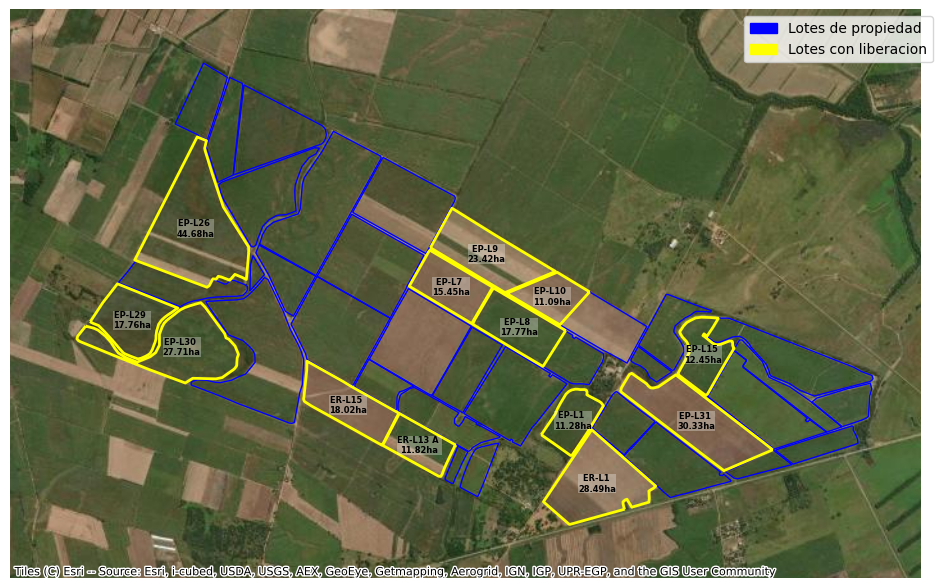

<Figure size 640x480 with 0 Axes>

In [304]:
apli = apli.to_crs(epsg=3857)
prop = prop.to_crs(epsg=3857)
# Asegúrate de que 'gdf' es tu GeoDataFrame que ya tiene una columna 'geometry' con polígonos
# Crea una figura y un eje con Matplotlib
fig, ax = plt.subplots(figsize=(12, 8))

prop.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=1)
# Grafica los polígonos utilizando la función plot de Geopandas
# 'edgecolor' es el color del borde, 'facecolor' es el color de relleno
apli.plot(ax=ax, edgecolor='yellow', facecolor='none', linewidth=2)

for idx, row in apli.iterrows():
    # Representa el punto central del polígono
    centroid = row.geometry.centroid
    # Anota el 'id' en el centro
    ax.annotate(
        text=row['unidad_05'] + ' \n' + str(round(row['area'], 2)) + 'ha', 
        xy=(centroid.x, centroid.y), 
        ha='center', 
        va='center', 
        weight=1000,
        fontsize=6,
        bbox=dict(facecolor=(1,1,1,0.3), edgecolor='none', pad=0))


# Agregar la imagen de satélite como mapa base con Contextily
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

# Ajustar los límites del eje al área de los polígonos
#ax.set_xlim(apli.total_bounds[[0, 2]])
#ax.set_ylim(apli.total_bounds[[1, 3]])

minx, miny, maxx, maxy = prop.total_bounds
ax.set_xlim(minx - 500, maxx + 500)
ax.set_ylim(miny - 400, maxy + 400)

handle1 = mpatches.Patch(color='blue', label='Lotes de propiedad')
handle2 = mpatches.Patch(color='yellow', label='Lotes con liberacion')

# Añade la leyenda con los handles creados
ax.legend(handles=[handle1, handle2])

# Omitir los ejes para una visualización más limpia
ax.axis('off')

# Muestra el gráfico
ruta_plano = ruta + '/planos/' + filename_img + '.jpeg'
fig.savefig(ruta_plano, dpi = 300, bbox_inches='tight')
plt.show()
plt.clf()

In [128]:
ruta

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

In [74]:
lista_imgs = []

In [75]:
lista_imgs.append(ruta_plano)

In [129]:
ruta_plano

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON/planos/41594_30_2023-09-11.jpeg'

In [130]:
data_rep

{'nro_reg': '000-5',
 'fecha': '2023-09-11',
 'nom_ca': 'AGROPECUARIA CAMPO DULCE S.R.L.',
 'cod_ca': 41594,
 'nom_prop': 'CAMPO DULCE',
 'cod_prop': 30,
 'inst': 50,
 'total': 270.26}

In [131]:
# Datos que quieres que contenga el QR
texto = '''
--UTEA--
--LIBERACION DE TRICHOGRAMMA--

Numero de Liberacion: {nro_reg}
Fecha de Liberacion: {fecha}
Nombre de Canero: {canero}
Codigo Canero: {cod_ca}
Propiedad: {prop}
Total Area Liberada: {area} ha'''\
.format(
    nro_reg=data_rep['nro_reg'], 
    fecha=data_rep['fecha'], 
    canero=data_rep['nom_ca'],
    cod_ca=data_rep['cod_ca'],
    prop=data_rep['nom_prop'],
    area=data_rep['total'])
# Generar el código QR
qr = qrcode.QRCode(
    version=1,
    error_correction=qrcode.constants.ERROR_CORRECT_L,
    box_size=10,
    border=4,
)
qr.add_data(texto)
qr.make(fit=True)

img = qr.make_image(fill_color="black", back_color="white")

filename_qr = 'qr_' + str(data_rep['cod_ca']) + '_' + str(data_rep['cod_prop']) + '_' + data_rep['fecha']
ruta_qr = ruta + '/planos/' + filename_qr + '.png'
# Guardar el código QR en un archivo
img.save(ruta_qr)

In [132]:
ruta_qr

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON/planos/qr_41594_30_2023-09-11.png'

In [133]:
ruta_plano

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON/planos/41594_30_2023-09-11.jpeg'

In [179]:
doc = DocxTemplate(ruta + "/templates/tpl_rpt_liberacion_tricho.docx")
in_line_plano = docxtpl.InlineImage(doc, image_descriptor=ruta_plano, width=Mm(170))
in_line_qr = docxtpl.InlineImage(doc, image_descriptor=ruta_qr, width=Mm(30))
context = {'data':data_rep2, 'lotes':lotes, 'plano':in_line_plano, 'qr':in_line_qr}
doc.render(context)
filename = str(data_rep['cod_ca']) + '_' + data_rep['nom_ca'] + '_' + data_rep['fecha']
doc.save(ruta + '/informes/' + filename + '.docx')